# WGCNA Network analysis of liver expression data in female mice

__Session 6 Tutorial for Module 6 DUBII 2021__

##### Costas Bouyioukos Universite de Paris and Anais Baudot CNRS

## 1. Preliminaries and data input

In [2]:
#  Code chunk 1
## Display the current working directory
#getwd();
## If necessary, change the path below to the directory where the data files are stored.
## "." means current directory.
#workingDir = ".";
#setwd(workingDir);
# Load the WGCNA package
library(WGCNA);
## The following setting is important, do not omit.
#options(stringsAsFactors = FALSE);
#Read in the female liver data set
femData = read.csv("data/LiverFemale3600.csv");
# Take a quick look at what is in the data set:
dim(femData);
names(femData);
head(femData);

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




[1] 3600  143

[1] "substanceBXH"   "gene_symbol"    "LocusLinkID"    "ProteomeID"    
  [5] "cytogeneticLoc" "CHROMOSOME"     "StartPosition"  "EndPosition"   
  [9] "F2_2"           "F2_3"           "F2_14"          "F2_15"         
 [13] "F2_19"          "F2_20"          "F2_23"          "F2_24"         
 [17] "F2_26"          "F2_37"          "F2_42"          "F2_43"         
 [21] "F2_45"          "F2_46"          "F2_47"          "F2_48"         
 [25] "F2_51"          "F2_52"          "F2_54"          "F2_63"         
 [29] "F2_65"          "F2_66"          "F2_68"          "F2_69"         
 [33] "F2_70"          "F2_71"          "F2_72"          "F2_78"         
 [37] "F2_79"          "F2_80"          "F2_81"          "F2_83"         
 [41] "F2_86"          "F2_87"          "F2_88"          "F2_89"         
 [45] "F2_107"         "F2_108"         "F2_109"         "F2_110"        
 [49] "F2_111"         "F2_112"         "F2_117"         "F2_119"        
 [53] "F2_125"         "F2_126"         "F2_127"         "F2_141"        
 [57] "F2_142"         "F2_143"         "F2_144"         "F2_145"        
 [61] "F2_154"         "F2_155"         "F2_156"         "F2_157"        
 [65] "F2_162"         "F2_163"         "F2_164"         "F2_165"        
 [69] "F2_166"         "F2_167"         "F2_169"         "F2_180"        
 [73] "F2_181"         "F2_182"         "F2_187"         "F2_188"        
 [77] "F2_189"         "F2_190"         "F2_191"         "F2_192"        
 [81] "F2_194"         "F2_195"         "F2_200"         "F2_201"        
 [85] "F2_212"         "F2_213"         "F2_214"         "F2_215"        
 [89] "F2_221"         "F2_222"         "F2_223"         "F2_224"        
 [93] "F2_225"         "F2_226"         "F2_227"         "F2_228"        
 [97] "F2_241"         "F2_242"         "F2_243"         "F2_244"        
[101] "F2_245"         "F2_247"         "F2_248"         "F2_261"        
[105] "F2_263"         "F2_264"         "F2_270"         "F2_271"        
[109] "F2_272"         "F2_278"         "F2_287"         "F2_288"        
[113] "F2_289"         "F2_290"         "F2_291"         "F2_296"        
[117] "F2_298"         "F2_299"         "F2_300"         "F2_302"        
[121] "F2_303"         "F2_304"         "F2_305"         "F2_306"        
[125] "F2_307"         "F2_308"         "F2_309"         "F2_310"        
[129] "F2_311"         "F2_312"         "F2_320"         "F2_321"        
[133] "F2_323"         "F2_324"         "F2_325"         "F2_326"        
[137] "F2_327"         "F2_328"         "F2_329"         "F2_330"        
[141] "F2_332"         "F2_355"         "F2_357"

,substanceBXH,gene_symbol,LocusLinkID,ProteomeID,cytogeneticLoc,CHROMOSOME,StartPosition,EndPosition,F2_2,F2_3,⋯,F2_324,F2_325,F2_326,F2_327,F2_328,F2_329,F2_330,F2_332,F2_355,F2_357
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,MMT00000044,1700007N18Rik,69339,286025,0,16,50911260,50912491,-0.01810,0.0642,⋯,0.047700,-0.0488,0.0168,-0.0309,0.02740,-0.0310,0.0660,-0.0199,-0.0146,0.065000
2,MMT00000046,Mast2,17776,157466,0,4,115215318,115372404,-0.07730,-0.0297,⋯,-0.049200,-0.0350,-0.0738,-0.1730,-0.07380,-0.2010,-0.0820,-0.0939,0.0192,-0.049900
3,MMT00000051,Ankrd32,105377,321939,0,13,74940309,74982847,-0.02260,0.0617,⋯,0.000612,0.1210,0.0996,0.1090,0.02730,0.1200,-0.0629,-0.0395,0.1090,0.000253
4,MMT00000076,0,383154,0,0,16,49345114,49477048,-0.00924,-0.1450,⋯,-0.270000,0.0803,0.0424,0.1610,0.05120,0.2410,0.3890,0.0251,-0.0348,0.114000
5,MMT00000080,Ldb2,16826,157383,0,5,43546124,43613704,-0.04870,0.0582,⋯,0.113000,-0.0859,-0.1340,0.0639,0.00731,0.1240,-0.0212,0.0870,0.0512,0.024300
6,MMT00000102,Rdhs,216453,0,10_70.0_cM,10,1337265,1347607,0.17600,-0.1890,⋯,-0.080000,-0.1200,0.1230,0.1870,0.05410,0.0699,0.0708,0.1450,-0.0399,0.037500


**Keep only the part of the data that contains the gene expression and keep the gene names as data frame index.**

In [3]:
#  Code chunk 2
datExpr0 = as.data.frame(t(femData[, -c(1:8)]));
names(datExpr0) = femData$substanceBXH;
rownames(datExpr0) = names(femData)[-c(1:8)];
datExpr0

,MMT00000044,MMT00000046,MMT00000051,MMT00000076,MMT00000080,MMT00000102,MMT00000149,MMT00000159,MMT00000207,MMT00000212,⋯,MMT00082822,MMT00082828,MMT00082829,MMT00082832,MMT00082847,MMT00082850,MMT00082869,MMT00082877,MMT00082899,MMT00082906
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F2_2,-0.01810000,-0.077300000,-0.02260000,-0.00924000,-0.04870000,0.17600000,0.07680000,-0.14800000,0.06870000,0.06090000,⋯,0.01350000,-0.15400000,-0.02180000,0.0310000,0.12900000,0.0467000,0.00991000,0.0291000,-0.00927000,0.04360000
F2_3,0.06420000,-0.029700000,0.06170000,-0.14500000,0.05820000,-0.18900000,0.18600000,0.17700000,0.10100000,0.05570000,⋯,-0.00971000,-0.07410000,0.09000000,0.0106000,0.11300000,-0.0252000,0.03190000,0.0408000,-0.12100000,0.08270000
F2_14,0.00006440,0.112000000,-0.12900000,0.02870000,-0.04830000,-0.06500000,0.21400000,-0.13200000,0.10900000,0.19100000,⋯,0.07090000,-0.13900000,0.02770000,-0.1310000,0.25500000,-0.1230000,0.08800000,0.0892000,-0.11400000,-0.08720000
F2_15,-0.05800000,-0.058900000,0.08710000,-0.04390000,-0.03710000,-0.00846000,0.12000000,0.10700000,-0.00858000,-0.12100000,⋯,-0.03130000,-0.07250000,0.01780000,0.0882000,0.07900000,0.0002760,-0.04820000,0.0493000,-0.05010000,-0.03900000
F2_19,0.04830000,0.044300000,-0.11500000,0.00425000,0.02510000,-0.00574000,0.02100000,-0.11900000,0.10500000,0.05410000,⋯,0.06950000,-0.11500000,0.06180000,0.2950000,0.12700000,-0.0560000,-0.02890000,-0.0389000,0.00718000,0.07100000
F2_20,-0.15197410,-0.093800000,-0.06502607,-0.23610000,0.08504274,-0.01807182,0.06222751,-0.05497686,-0.02441415,0.06343181,⋯,0.17434920,-0.09405315,0.11766460,0.1161963,0.11803810,-0.1171272,-0.09774204,-0.0745188,0.31857000,0.20477010
F2_23,-0.00129000,0.093400000,0.00249000,-0.06900000,0.04450000,-0.12500000,0.22600000,0.05690000,0.11600000,0.14600000,⋯,0.06570000,-0.16300000,0.13600000,0.0765000,0.18100000,-0.0342000,-0.09160000,0.0880000,-0.18200000,0.06190000
F2_24,-0.23600000,0.026900000,-0.10200000,0.01440000,0.00167000,-0.06820000,0.31100000,-0.15200000,0.02230000,0.04650000,⋯,-0.03400000,-0.14800000,0.05580000,-0.1110000,0.05100000,-0.0680000,-0.09360000,-0.1130000,-1.47000000,-0.00794000
F2_26,-0.03070000,-0.133000000,0.14200000,0.03630000,-0.06800000,0.12500000,-0.20700000,-0.04470000,0.02430000,-0.00023900,⋯,-0.04220000,0.08290000,-0.05070000,0.0828000,-0.11700000,0.1790000,0.16000000,-0.1110000,0.46900000,-0.12500000


**Check if there are genes with missing values.**

In [4]:
#  Code chunk 3
gsg = goodSamplesGenes(datExpr0, verbose = 3);
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

**All genes are OK!**

#### Cluster the transposed matrix to identify sample outliers.

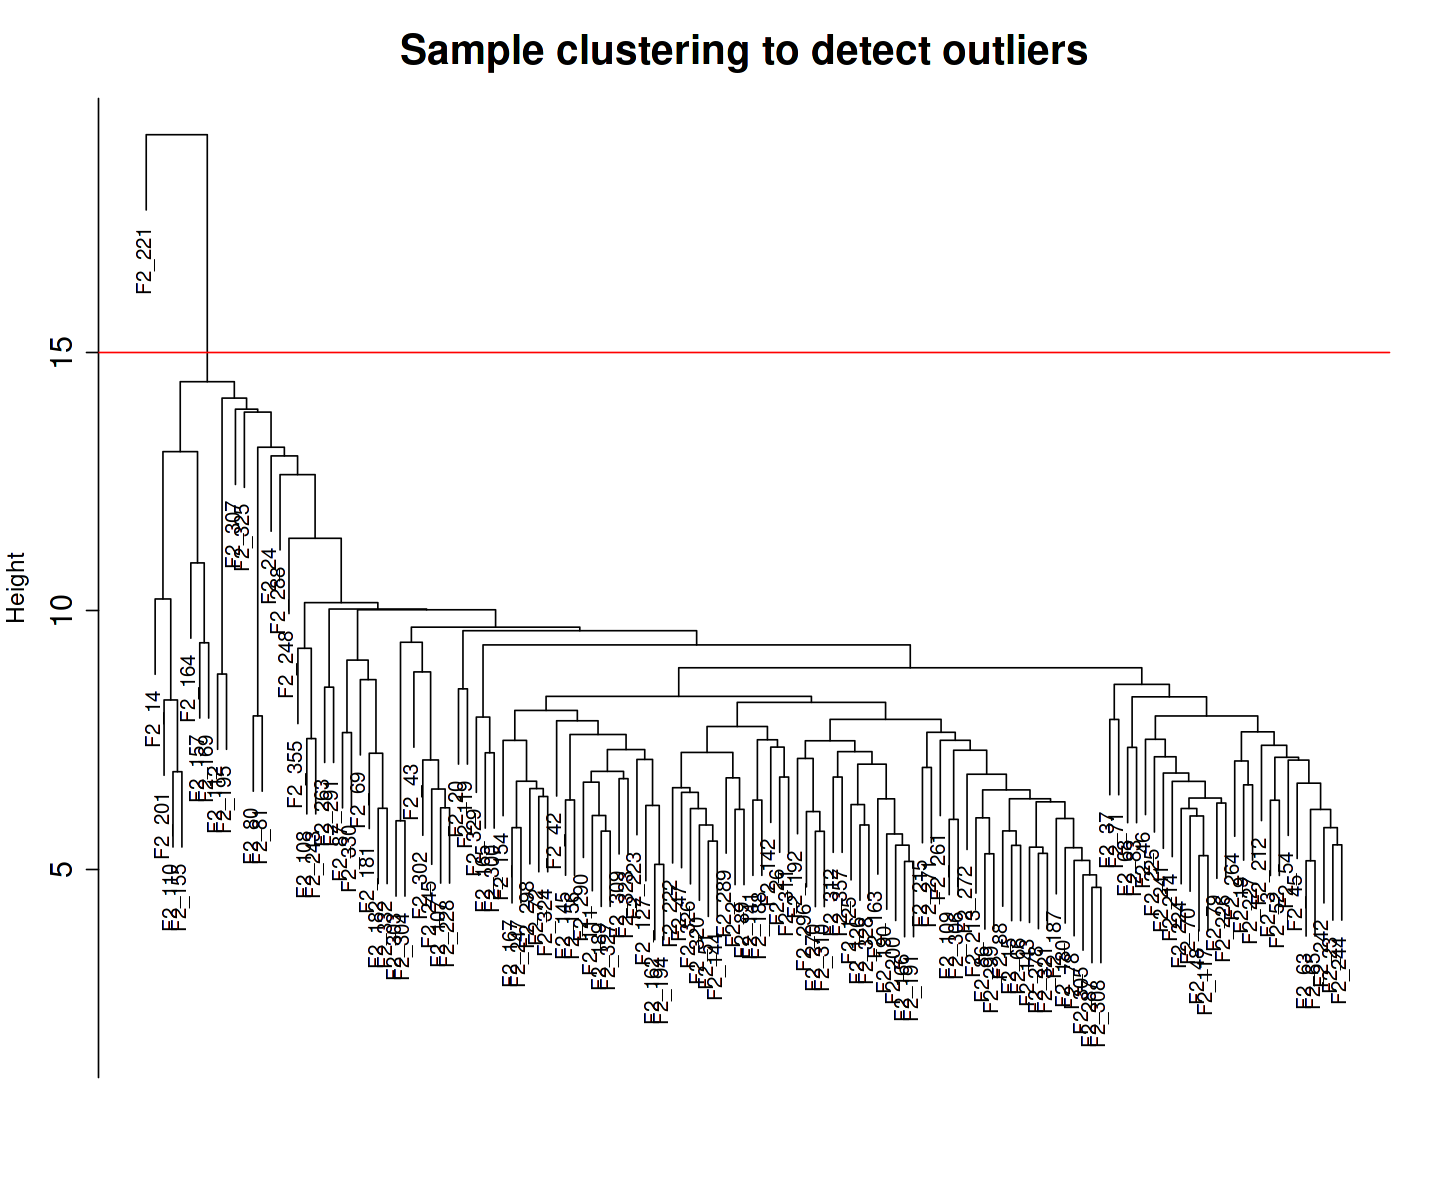

In [5]:
#  Code chunk 4
sampleTree = hclust(dist(datExpr0), method = "average");
# Plot the sample tree: Open a graphic output window of size 12 by 10 inches
# The user should change the dimensions if the window is too large or too small.
options(repr.plot.width = 12, repr.plot.height = 10)
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="",
     cex.lab = 1.2, cex.axis = 1.5, cex.main = 2)
# Plot a line to show the cut
abline(h = 15, col = "red");

**Identify the outlier.**

In [6]:
#  Code chunk 5
# Determine cluster under the line
clust = cutreeStatic(sampleTree, cutHeight = 15, minSize = 10)
table(clust)

clust
  0   1 
  1 134 

**Remove the outlier and construct the main data frame.**

In [7]:
#  Code chunk 5
# clust 1 contains the samples we want to keep.
keepSamples = (clust==1)
datExpr = datExpr0[keepSamples, ]
nGenes = ncol(datExpr)
nSamples = nrow(datExpr)

#### Import the clinical data, preapre and clean it.

In [8]:
#  Code chunk 7
traitData = read.csv("data/ClinicalTraits.csv");
dim(traitData)
names(traitData)
# remove columns that hold information we do not need.
allTraits = traitData[, -c(31, 16)];
allTraits = allTraits[, c(2, 11:36) ];
dim(allTraits)
names(allTraits)
# Form a data frame analogous to expression data that will hold the clinical traits.
femaleSamples = rownames(datExpr);
traitRows = match(femaleSamples, allTraits$Mice);
datTraits = allTraits[traitRows, -1];
rownames(datTraits) = allTraits[traitRows, 1];

[1] 361  38

[1] "X"                  "Mice"               "Number"            
 [4] "Mouse_ID"           "Strain"             "sex"               
 [7] "DOB"                "parents"            "Western_Diet"      
[10] "Sac_Date"           "weight_g"           "length_cm"         
[13] "ab_fat"             "other_fat"          "total_fat"         
[16] "comments"           "X100xfat_weight"    "Trigly"            
[19] "Total_Chol"         "HDL_Chol"           "UC"                
[22] "FFA"                "Glucose"            "LDL_plus_VLDL"     
[25] "MCP_1_phys"         "Insulin_ug_l"       "Glucose_Insulin"   
[28] "Leptin_pg_ml"       "Adiponectin"        "Aortic.lesions"    
[31] "Note"               "Aneurysm"           "Aortic_cal_M"      
[34] "Aortic_cal_L"       "CoronaryArtery_Cal" "Myocardial_cal"    
[37] "BMD_all_limbs"      "BMD_femurs_only"

[1] 361  27

[1] "Mice"               "weight_g"           "length_cm"         
 [4] "ab_fat"             "other_fat"          "total_fat"         
 [7] "X100xfat_weight"    "Trigly"             "Total_Chol"        
[10] "HDL_Chol"           "UC"                 "FFA"               
[13] "Glucose"            "LDL_plus_VLDL"      "MCP_1_phys"        
[16] "Insulin_ug_l"       "Glucose_Insulin"    "Leptin_pg_ml"      
[19] "Adiponectin"        "Aortic.lesions"     "Aneurysm"          
[22] "Aortic_cal_M"       "Aortic_cal_L"       "CoronaryArtery_Cal"
[25] "Myocardial_cal"     "BMD_all_limbs"      "BMD_femurs_only"

**Repeat the sample clustering together with a heat-map of the phenotypic data.**

In [9]:
datTraits

,weight_g,length_cm,ab_fat,other_fat,total_fat,X100xfat_weight,Trigly,Total_Chol,HDL_Chol,UC,⋯,Leptin_pg_ml,Adiponectin,Aortic.lesions,Aneurysm,Aortic_cal_M,Aortic_cal_L,CoronaryArtery_Cal,Myocardial_cal,BMD_all_limbs,BMD_femurs_only
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
F2_2,38.0,10.5,3.81,2.78,6.59,17.342105,14,1646,34,668,⋯,NA,NA,224500,56,5,0,0,0,NA,NA
F2_3,33.5,10.8,1.70,2.05,3.75,11.194030,109,1216,27,402,⋯,15148.76,14.339,296250,8,4,NA,0,0,NA,NA
F2_14,33.9,10.0,1.29,1.67,2.96,8.731563,2,834,17,354,⋯,6188.74,15.439,486313,27,12,NA,1,8,NA,NA
F2_15,44.3,10.3,3.62,3.34,6.96,15.711061,71,1565,41,536,⋯,18400.26,11.124,180750,0,0,NA,0,4,NA,NA
F2_19,32.9,9.7,2.08,1.85,3.93,11.945289,55,1060,41,411,⋯,8438.70,16.842,113000,0,0,NA,0,0,NA,NA
F2_20,44.8,10.3,3.72,3.20,6.92,15.446429,34,1172,39,448,⋯,41801.54,13.498,166750,6,0,NA,0,0,NA,NA
F2_23,36.9,10.0,2.07,2.80,4.87,13.197832,198,1530,36,636,⋯,24133.54,14.511,234000,28,8,NA,0,0,NA,NA
F2_24,39.5,10.0,2.79,2.62,5.41,13.696203,186,1434,23,517,⋯,52360.00,13.813,267500,33,8,NA,0,1,NA,NA
F2_26,42.5,9.9,2.68,4.56,7.24,17.035294,357,1758,56,644,⋯,126880.00,14.118,198000,0,0,0,0,0,NA,NA


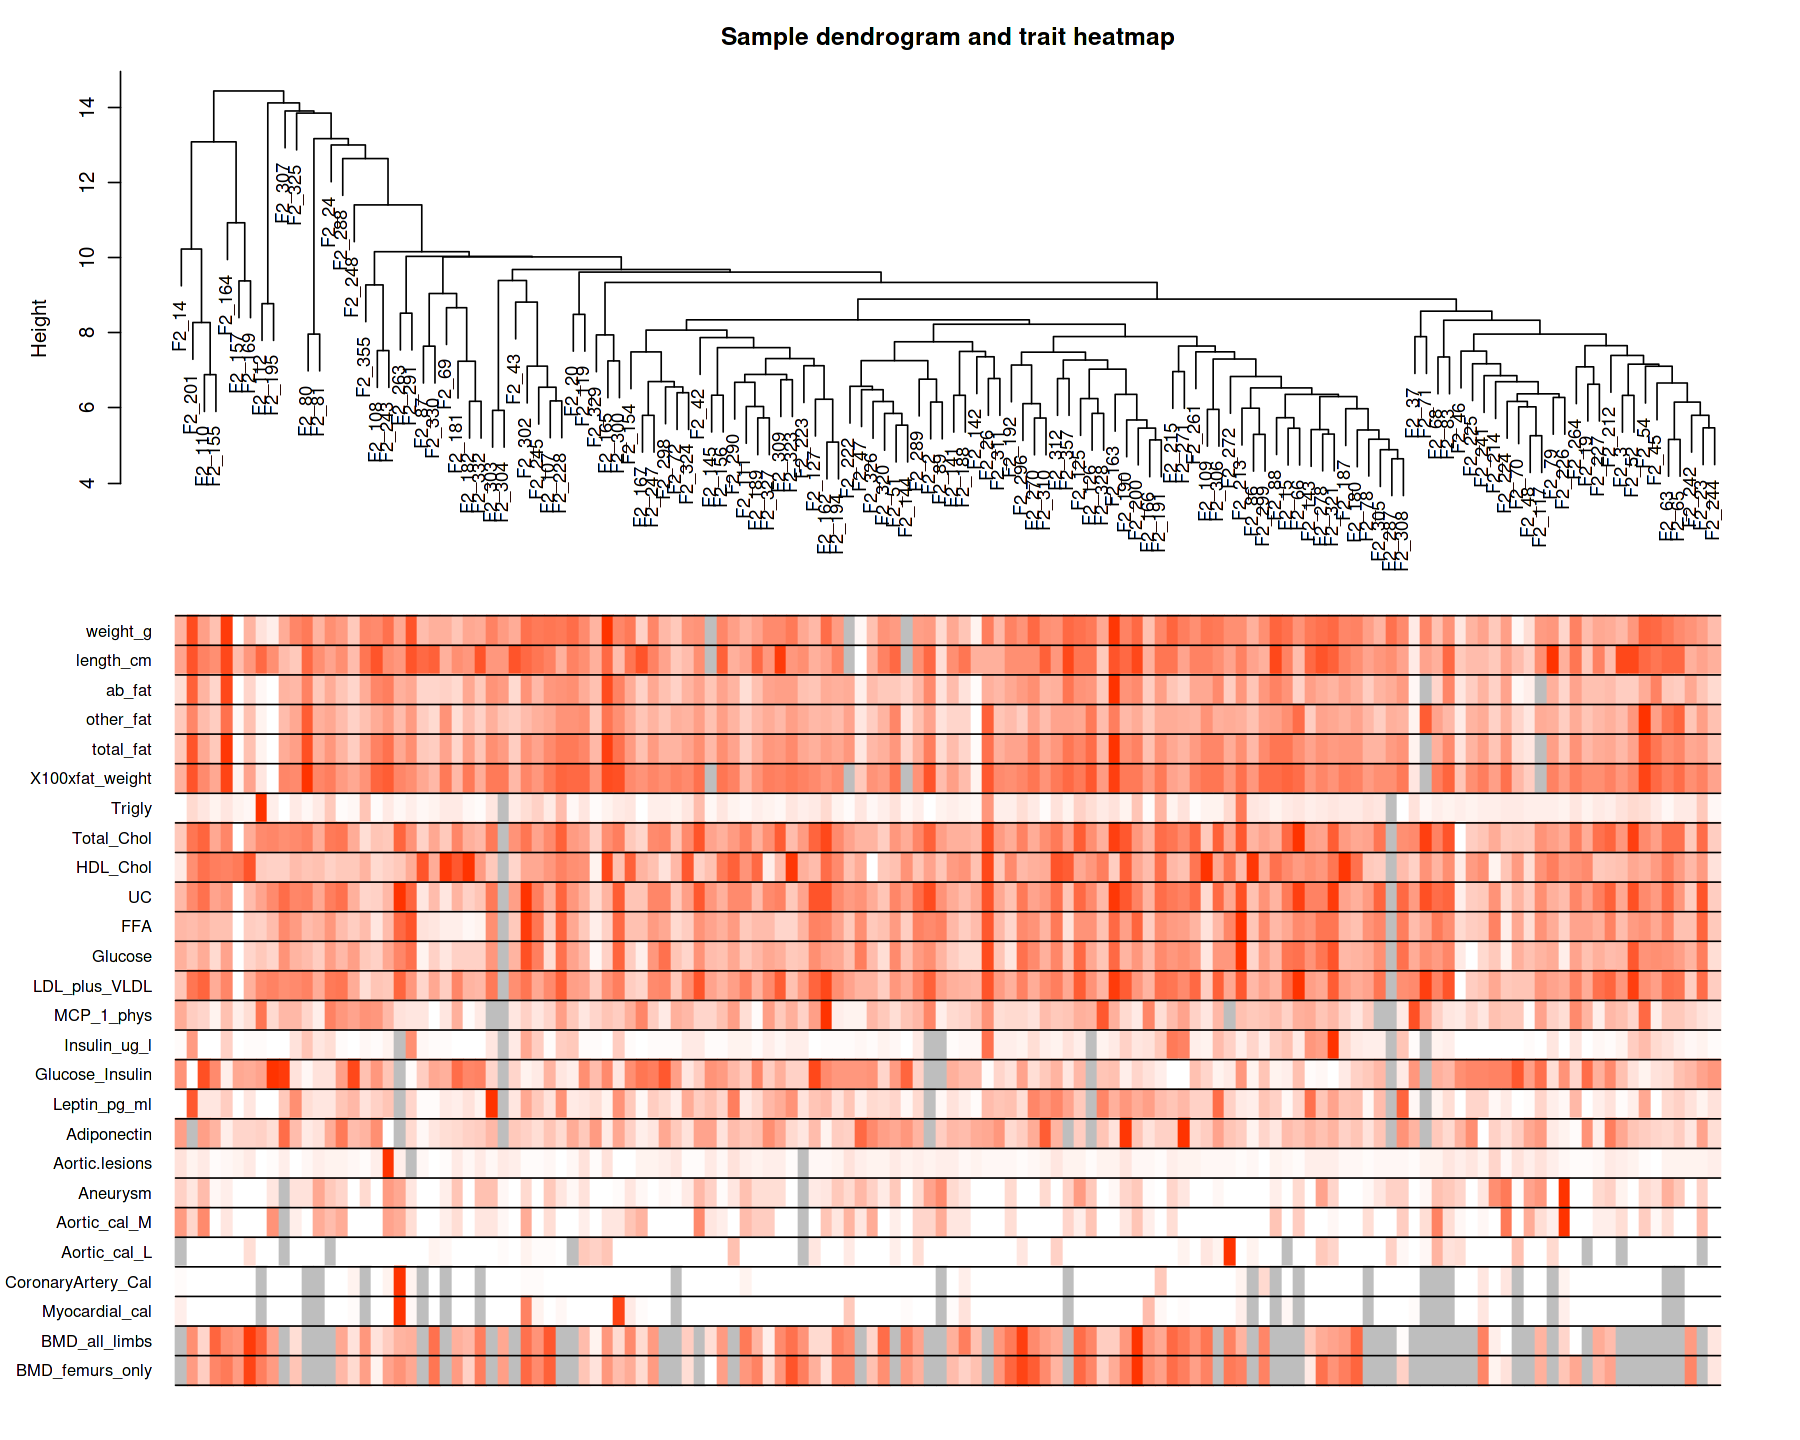

In [10]:
#  Code chunk 8
# Re-cluster samples
sampleTree2 = hclust(dist(datExpr), method = "average")
# Convert traits to a color representation: white means low, red means high, grey means missing entry
traitColors = numbers2colors(datTraits, signed = FALSE);
# Plot the sample dendrogram and the colors underneath.
options(repr.plot.width = 15, repr.plot.height = 12)
plotDendroAndColors(sampleTree2, traitColors,
                    groupLabels = names(datTraits),
                    main = "Sample dendrogram and trait heatmap")

**Save the analysis to an RData file.**

In [11]:
# Code chunk 9
save(datExpr, datTraits, file = "FemaleLiver-01-dataInput.RData")

## 2. Automatic network construction and module detection

In [12]:
#  Code chunk 10
# Allow multi-threading within WGCNA. This helps speed up certain calculations.
# At present this call is necessary for the code to work.
# Any error here may be ignored but you may want to update WGCNA if you see one.
# See note above.
allowWGCNAThreads()
# Load the data saved in the first part
lnames = load(file = "FemaleLiver-01-dataInput.RData");
#The variable lnames contains the names of loaded variables.
lnames

Allowing multi-threading with up to 8 threads.


[1] "datExpr"   "datTraits"

#### The most convenient and automatic way to detect modules and construct a network with WGCNA.

Here the developers of WGCNA are proposing a "soft thresholding" approach. This method identifies a power -to wich the correlation matrix is raised in order to calculate the network adjacency matrix- based on the criterion of scale-free approximation.

pickSoftThreshold: will use block size 3600.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 3600 of 3600
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0278  0.345          0.456  747.00  762.0000 1210.0
2      2   0.1260 -0.597          0.843  254.00  251.0000  574.0
3      3   0.3400 -1.030          0.972  111.00  102.0000  324.0
4      4   0.5060 -1.420          0.973   56.50   47.2000  202.0
5      5   0.6810 -1.720          0.940   32.20   25.1000  134.0
6      6   0.9020 -1.500          0.962   19.90   14.5000   94.8
7      7   0.9210 -1.670          0.917   13.20    8.6800   84.1
8      8   0.9040 -1.720          0.876    9.25    5.3900   76.3
9      9   0.8590 -1.700          0.836    6.80    3.5600   70.5
10    10   0.8330 -1.660          0.831    5.19    2.3800   65.8
11    12   0.8530 -1.480          0.911    3.33    1.1500   58.1
12    14   0.8760 -1.380          0.949    2.35    0.5740   51.9


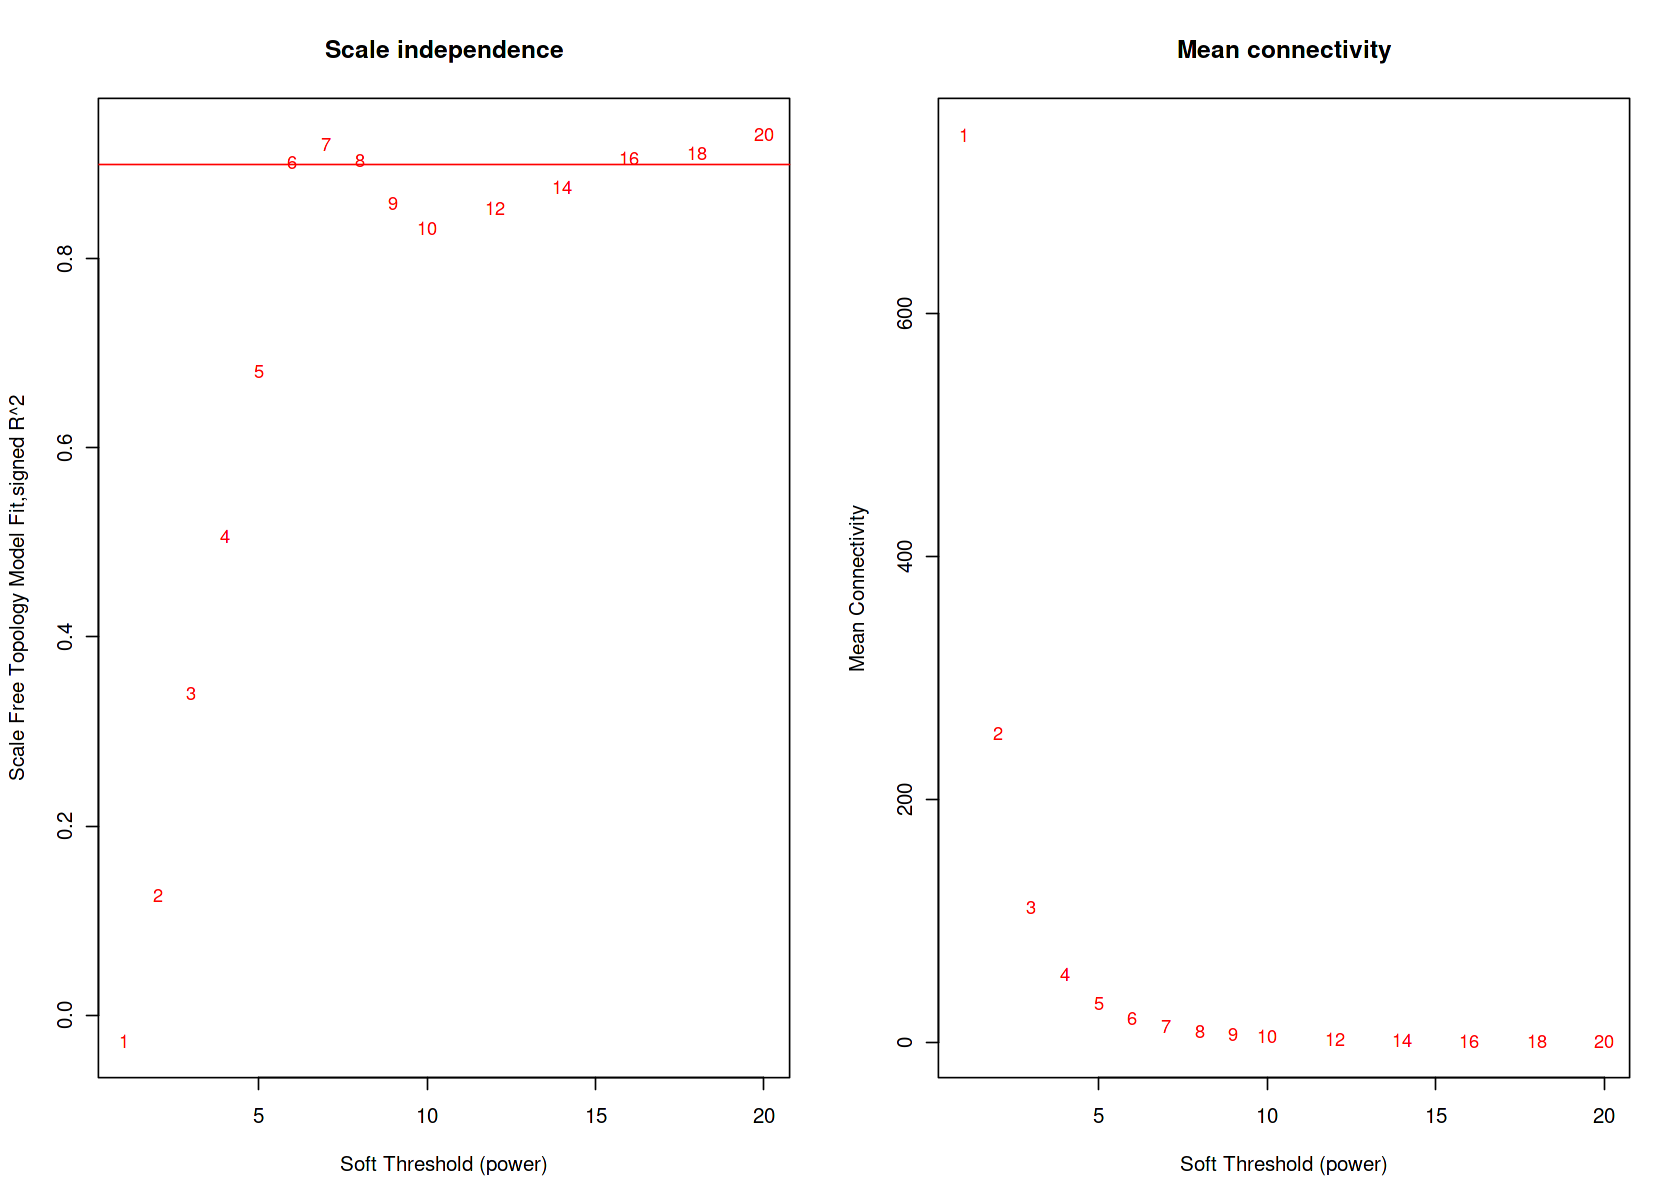

In [13]:
#  Code chunk 11
# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to = 20, by = 2))
# Call the network topology analysis function
sft = pickSoftThreshold(datExpr, powerVector = powers, verbose = 5)
# Plot the results:
par(mfrow = c(1, 2));
options(repr.plot.width = 14, repr.plot.height = 10);
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab = "Soft Threshold (power)", ylab = "Scale Free Topology Model Fit,signed R^2", type = "n",
     main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels = powers, cex = 0.9, col = "red");
# this line corresponds to using an R^2 cut-off of h
abline(h = 0.90, col = "red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab = "Soft Threshold (power)", ylab = "Mean Connectivity", type = "n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels = powers, cex = 0.9, col = "red")

### The actual network construction step.

We choose 6 (or 7 for signed) as the lowest power that constructs a scale free topology.
And then we instruct the function to generate modules of size 30, merge modules which are more than 25% similar and save the Topological Overlap Matrix in an object.

In [14]:
#  Code chunk 12
net = blockwiseModules(datExpr, power = 7,
                       TOMType = "signed", minModuleSize = 30,
                       reassignThreshold = 1e-6, mergeCutHeight = 0.25,
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs = TRUE, nThreads = 8,
                       saveTOMFileBase = "femaleMouseTOM",
                       verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
Cluster size 3600 broken into 2108 1492 
Cluster size 2108 broken into 1126 982 
Done cluster 1126 
Done cluster 982 
Done cluster 2108 
Done cluster 1492 
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 8 parallel threads.
     Fraction of slow calculations: 0.365708
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file femaleMouseTOM-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 7 genes from module 2 because their KME is too low.
     ..removing 1 genes from module 5 because their KME is too low.
  ..reassigning 19 genes from module 1 to modules with higher KME.
  ..reassigning 20 genes from module 2 to modules with higher KME.
  ..reassigning 28 genes fro

**Here is the modules (as numbers and not colours yet) of each module with its size.**

In [15]:
colnames(net$MEs)

[1] "ME10" "ME1"  "ME6"  "ME5"  "ME16" "ME12" "ME3"  "ME2"  "ME8"  "ME4" 
[11] "ME13" "ME19" "ME18" "ME7"  "ME17" "ME9"  "ME11" "ME14" "ME15" "ME0"

**Here is the resuling plot dendrogram of the module construction and the clustering of the genes.**

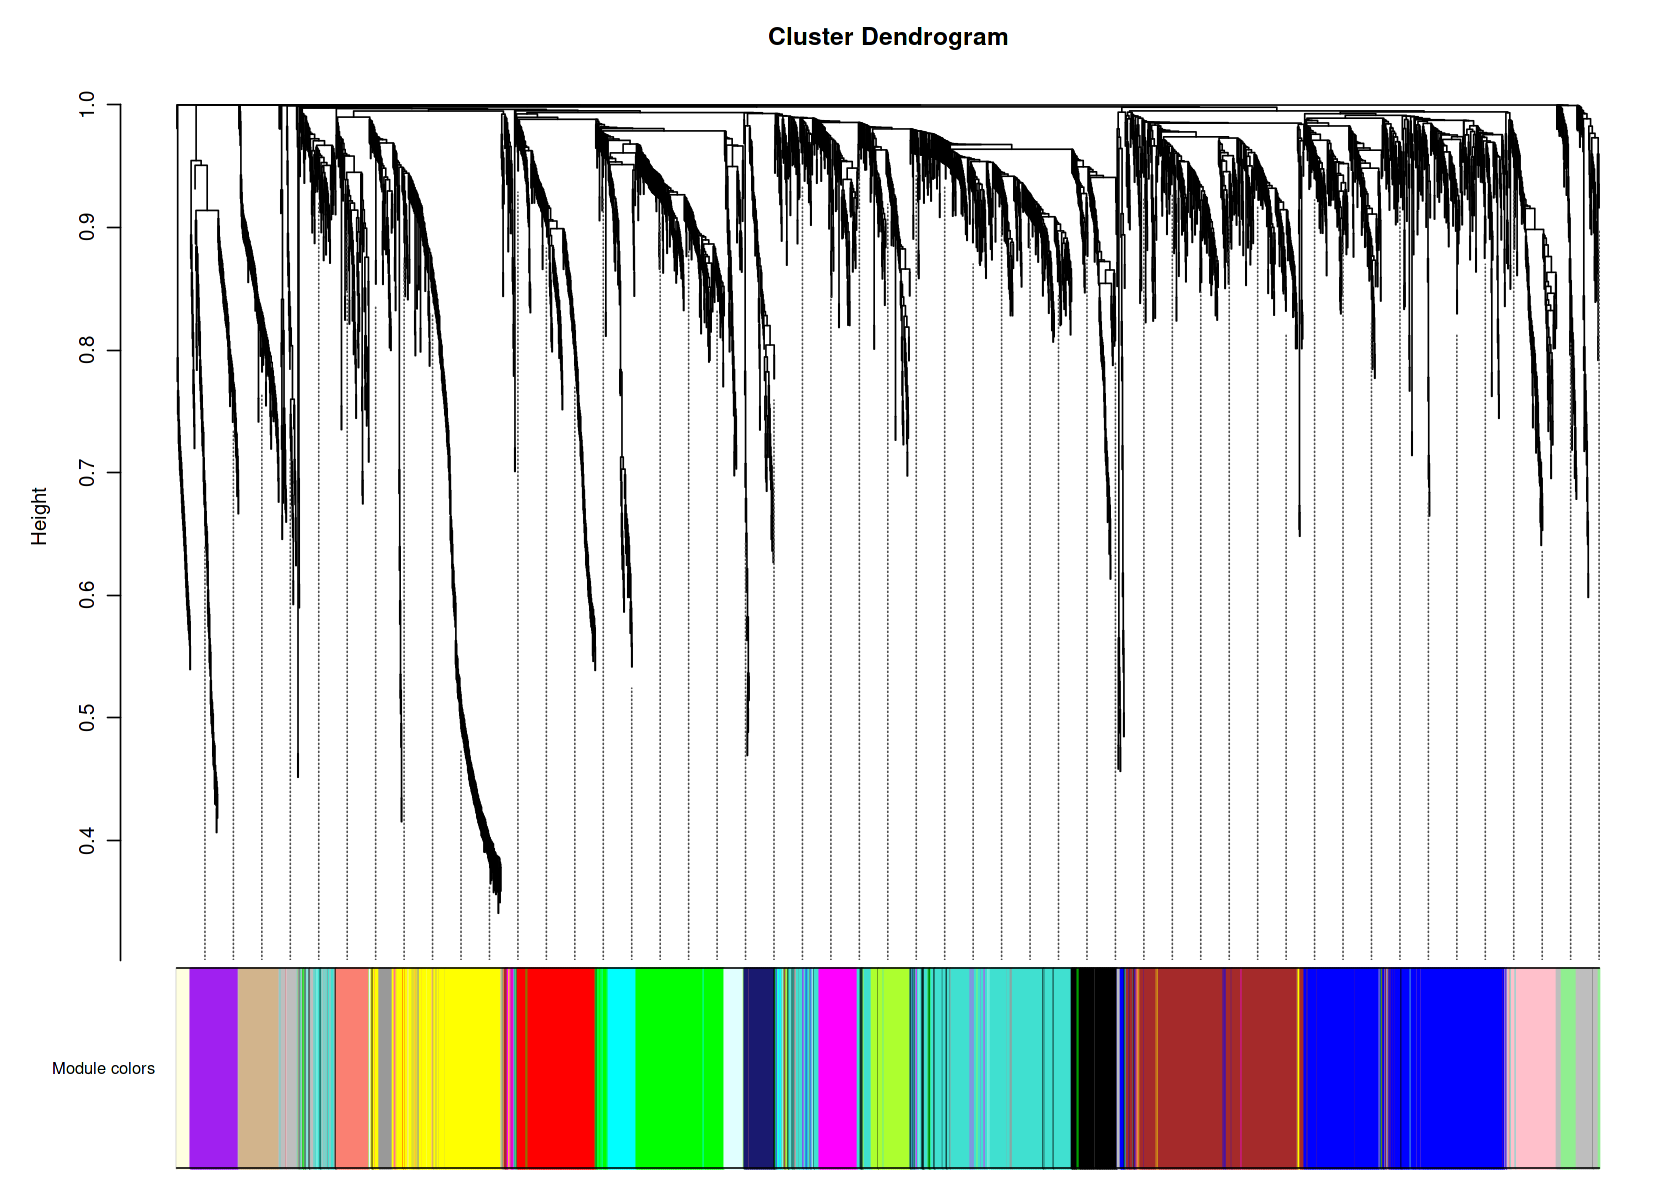

In [16]:
#  Code chunk 13
# Convert labels to colors for plotting
mergedColors = labels2colors(net$colors)
#mergedColors
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(net$dendrograms[[1]], mergedColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

**Save results of this part in an .RData file.**

In [17]:
#  Code chunk 14
moduleLabels = net$colors
moduleColors = labels2colors(net$colors)
MEs = net$MEs;
geneTree = net$dendrograms[[1]];
save(MEs, moduleLabels, moduleColors, geneTree,
     file = "FemaleLiver-02-networkConstruction-auto.RData")

## 3. Relating modules to external information and identifying important genes

In [18]:
#  Code chunk 15
lnames = load(file = "FemaleLiver-01-dataInput.RData");
#The variable lnames contains the names of loaded variables.
lnames
# Load network data saved in the second part.
lnames = load(file = "FemaleLiver-02-networkConstruction-auto.RData");
lnames

[1] "datExpr"   "datTraits"

[1] "MEs"          "moduleLabels" "moduleColors" "geneTree"

### Quantifying module–trait associations

Here we identify modules that are significantly associated with the measured clinical traits.
We already have a computed summary profile (eigengene) for each module, so then we simply correlate eigengenes with phenotypic traits and look for the most significant associations:

In [19]:
#  Code chunk 16
# Define numbers of genes and samples
nGenes = ncol(datExpr);
nSamples = nrow(datExpr);
# Recalculate MEs with color labels
MEs0 = moduleEigengenes(datExpr, moduleColors)$eigengenes
MEs = orderMEs(MEs0)
moduleTraitCor = cor(MEs, datTraits, use = "p");
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples);

#### Visualise the module-trait association.

Each module eigengene and its correlation coefficient are ploted here.
Since we have many a colour code aids the interprettion of the plot.

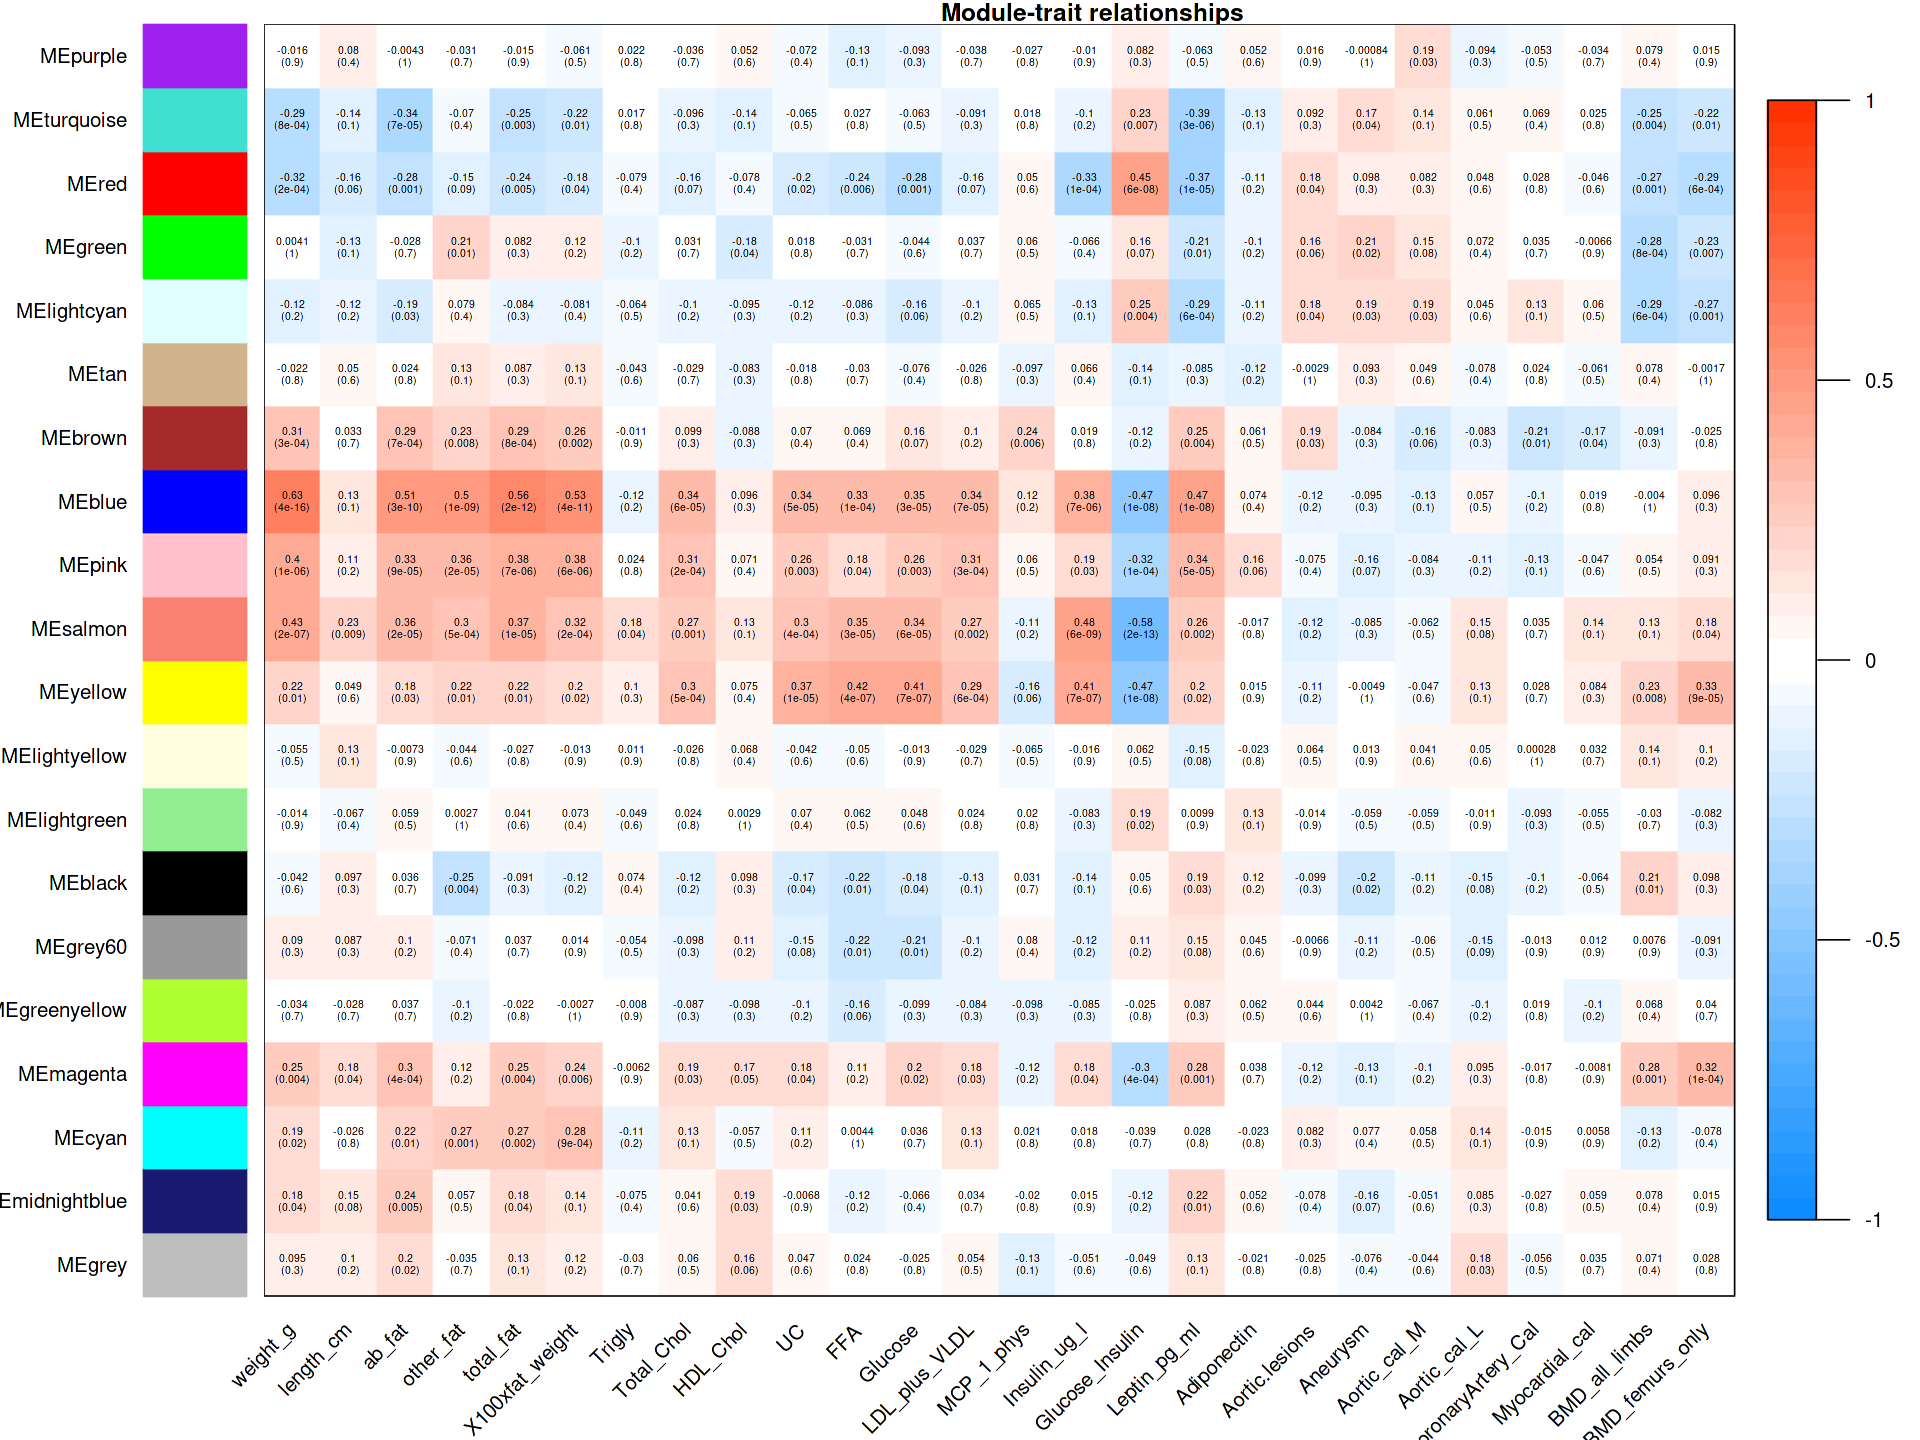

In [20]:
#  Code chunk 17
options(repr.plot.width=16, repr.plot.height=12)
# Will display correlations and their p-values
textMatrix =  paste(signif(moduleTraitCor, 2), "\n(",
                           signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 11, 1, 0));
# Display the correlation values within a heatmap plot
labeledHeatmap(Matrix = moduleTraitCor,
               xLabels = names(datTraits),
               yLabels = names(MEs),
               ySymbols = names(MEs),
               colorLabels = FALSE,
               colors = blueWhiteRed(50),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 0.5,
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))

In [21]:
#  Code chunk 18
names(datExpr)[moduleColors=="salmon"]

[1] "MMT00000743" "MMT00003575" "MMT00004227" "MMT00004671" "MMT00005139"
 [6] "MMT00005900" "MMT00006408" "MMT00007700" "MMT00008523" "MMT00008789"
[11] "MMT00009011" "MMT00009506" "MMT00011470" "MMT00012566" "MMT00012675"
[16] "MMT00013152" "MMT00014573" "MMT00016374" "MMT00018029" "MMT00022101"
[21] "MMT00022878" "MMT00024116" "MMT00025608" "MMT00026453" "MMT00026786"
[26] "MMT00026973" "MMT00028408" "MMT00028522" "MMT00029681" "MMT00030442"
[31] "MMT00030469" "MMT00030953" "MMT00031178" "MMT00032331" "MMT00032979"
[36] "MMT00033522" "MMT00035545" "MMT00036605" "MMT00038017" "MMT00038022"
[41] "MMT00039557" "MMT00041316" "MMT00045905" "MMT00046250" "MMT00046920"
[46] "MMT00046994" "MMT00047560" "MMT00048501" "MMT00049025" "MMT00050061"
[51] "MMT00050881" "MMT00052924" "MMT00053283" "MMT00053523" "MMT00054020"
[56] "MMT00054102" "MMT00054225" "MMT00054501" "MMT00055476" "MMT00057115"
[61] "MMT00058422" "MMT00058679" "MMT00059097" "MMT00060232" "MMT00060307"
[66] "MMT00061424" "MMT00061944" "MMT00062714" "MMT00063965" "MMT00063985"
[71] "MMT00067143" "MMT00067195" "MMT00067953" "MMT00068222" "MMT00068995"
[76] "MMT00069238" "MMT00069557" "MMT00069683" "MMT00071535" "MMT00072142"
[81] "MMT00074126" "MMT00074306" "MMT00075896" "MMT00077367" "MMT00077659"
[86] "MMT00078546" "MMT00079348" "MMT00081203" "MMT00082255" "MMT00082677"

#### Probe annotation file provided by the manufacturer to facilitate functional annotation.

In [22]:
#  Code chunk 19
annot = read.csv(file = "data/GeneAnnotation.csv");
dim(annot)
names(annot)
probes = names(datExpr)
probes2annot = match(probes, annot$substanceBXH)
# The following is the number or probes without annotation:
sum(is.na(probes2annot))
# Should return 0.

[1] 23388    34

[1] "X"                        "ID"                      
 [3] "arrayname"                "substanceBXH"            
 [5] "gene_symbol"              "LocusLinkID"             
 [7] "OfficialGeneSymbol"       "OfficialGeneName"        
 [9] "LocusLinkSymbol"          "LocusLinkName"           
[11] "ProteomeShortDescription" "UnigeneCluster"          
[13] "LocusLinkCode"            "ProteomeID"              
[15] "ProteomeCode"             "SwissprotID"             
[17] "OMIMCode"                 "DirectedTilingPriority"  
[19] "AlternateSymbols"         "AlternateNames"          
[21] "SpeciesID"                "cytogeneticLoc"          
[23] "Organism"                 "clustername"             
[25] "reporterid"               "probeid"                 
[27] "sequenceid"               "clusterid"               
[29] "chromosome"               "startcoordinate"         
[31] "endcoordinate"            "strand"                  
[33] "sequence_3_to_5_prime"    "sequence_5_to_3_prime"

[1] 0

#### Collect all the information for significant genes related to body weight.

In [23]:
weight = as.data.frame(datTraits$weight_g);
geneModuleMembership = as.data.frame(cor(datExpr, MEs, use = "p"));
MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples));
modNames = substring(names(MEs), 3);
names(geneModuleMembership) = paste("MM", modNames, sep="");
names(MMPvalue) = paste("p.MM", modNames, sep="");
geneTraitSignificance = as.data.frame(cor(datExpr, weight, use = "p"));
GSPvalue = as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples));
names(geneTraitSignificance) = paste("GS.", names(weight), sep="");
names(GSPvalue) = paste("p.GS.", names(weight), sep="");

#  Code chunk 20
# Create the starting data frame
geneInfo0 = data.frame(substanceBXH = probes,
                      geneSymbol = annot$gene_symbol[probes2annot],
                      LocusLinkID = annot$LocusLinkID[probes2annot],
                      moduleColor = moduleColors,
                      geneTraitSignificance,
                      GSPvalue)
# Order modules by their significance for weight
modOrder = order(-abs(cor(MEs, weight, use = "p")));
# Add module membership information in the chosen order
for (mod in 1:ncol(geneModuleMembership))
{
  oldNames = names(geneInfo0)
  geneInfo0 = data.frame(geneInfo0, geneModuleMembership[, modOrder[mod]],
                         MMPvalue[, modOrder[mod]]);
  names(geneInfo0) = c(oldNames, paste("MM.", modNames[modOrder[mod]], sep=""),
                       paste("p.MM.", modNames[modOrder[mod]], sep=""))
}

# Order the genes in the geneInfo variable first by module color, then by geneTraitSignificance
geneOrder = order(geneInfo0$moduleColor, -abs(geneInfo0$GS.datTraits.weight_g));
geneInfo = geneInfo0[geneOrder, ]

##### Save the results in an output file for further analysis.

In [24]:
#  Code chunk 21
write.csv(geneInfo, file = "geneInfo.csv")

## 4. Interfacing network analysis with other data such as functional annotation and gene ontology

In [25]:
#  Code chunk 22
# Load the expression and trait data saved in the first part
lnames = load(file = "FemaleLiver-01-dataInput.RData");
#The variable lnames contains the names of loaded variables.
lnames
# Load network data saved in the second part.
lnames = load(file = "FemaleLiver-02-networkConstruction-auto.RData");
lnames

[1] "datExpr"   "datTraits"

[1] "MEs"          "moduleLabels" "moduleColors" "geneTree"

In [26]:
#  Code chunk 23
# Read in the probe annotation
annot = read.csv(file = "data/GeneAnnotation.csv");
# Match probes in the data set to the probe IDs in the annotation file
probes = names(datExpr)
probes2annot = match(probes, annot$substanceBXH)
# Get the corresponding Locuis Link IDs
allLLIDs = annot$LocusLinkID[probes2annot];
# $ Choose interesting modules
intModules = c("brown", "red", "salmon")
for (module in intModules)
{
  # Select module probes
  modGenes = (moduleColors==module)
  # Get their entrez ID codes
  modLLIDs = allLLIDs[modGenes];
  # Write them into a file
  fileName = paste("LocusLinkIDs-", module, ".txt", sep="");
  write.table(as.data.frame(modLLIDs), file = fileName,
              row.names = FALSE, col.names = FALSE)
}
# As background in the enrichment analysis, we will use all probes in the analysis.
fileName = paste("LocusLinkIDs-all.txt", sep="");
write.table(as.data.frame(allLLIDs), file = fileName,
            row.names = FALSE, col.names = FALSE)

In [27]:
#  Code chunk 24
GOenr = GOenrichmentAnalysis(moduleColors, allLLIDs, organism = "mouse", nBestP = 10);

Warning message in GOenrichmentAnalysis(moduleColors, allLLIDs, organism = "mouse", :
“This function is deprecated and will be removed in the near future. 
We suggest using the replacement function enrichmentAnalysis 
in R package anRichment, available from the following URL:
https://labs.genetics.ucla.edu/horvath/htdocs/CoexpressionNetwork/GeneAnnotation/”
Loading required package: org.Mm.eg.db

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data

 GOenrichmentAnalysis: loading annotation data...
  ..of the 3038  Entrez identifiers submitted, 2825 are mapped in current GO categories.
  ..will use 2825 background genes for enrichment calculations.
  ..preparing term lists (this may take a while).. 
  ..working on label set 1 ..
    ..calculating enrichments (this may also take a while)..
    ..putting together terms with highest enrichment significance..


In [28]:
#anRichment(moduleColors, allLLIDs, organism = "mouse", nBestP = 10);  # Does not work yet.

In [29]:
#  Code chunk 25
tab = GOenr$bestPTerms[[4]]$enrichment

In [30]:
#  Code chunk 26
names(tab)

[1] "module"             "modSize"            "bkgrModSize"       
 [4] "rank"               "enrichmentP"        "BonferoniP"        
 [7] "nModGenesInTerm"    "fracOfBkgrModSize"  "fracOfBkgrTermSize"
[10] "bkgrTermSize"       "termID"             "termOntology"      
[13] "termName"           "termDefinition"

In [31]:
#  Code chunk 27
write.table(tab, file = "GOEnrichmentTable.csv", sep = ",", quote = TRUE, row.names = FALSE)

In [32]:
#  Code chunk 28
keepCols = c(1, 2, 5, 6, 7, 12, 13);
screenTab = tab[, keepCols];
# Round the numeric columns to 2 decimal places:
numCols = c(3, 4);
screenTab[, numCols] = signif(apply(screenTab[, numCols], 2, as.numeric), 2)
# Truncate the the term name to at most 40 characters
screenTab[, 7] = substring(screenTab[, 7], 1, 40)
# Shorten the column names:
colnames(screenTab) = c("module", "size", "p-val", "Bonf", "nInTerm", "ont", "term name");
rownames(screenTab) = NULL;
# Set the width of R's output. The reader should play with this number to obtain satisfactory output.
options(width=95)
# Finally, display the enrichment table:
screenTab

module,size,p-val,Bonf,nInTerm,ont,term name
<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
black,121,1.3e-06,2.3e-02,6,CC,large ribosomal subunit
black,121,1.6e-06,2.9e-02,14,CC,ribonucleoprotein complex
black,121,1.9e-06,3.5e-02,8,CC,ribosome
black,121,9.5e-06,1.7e-01,5,CC,cytosolic large ribosomal subunit
black,121,4.1e-05,7.4e-01,6,CC,cytosolic ribosome
black,121,1.9e-04,1.0e+00,5,MF,structural constituent of ribosome
black,121,2.8e-04,1.0e+00,15,MF,RNA binding
black,121,6.0e-04,1.0e+00,8,BP,canonical Wnt signaling pathway
black,121,7.2e-04,1.0e+00,9,MF,transcription coregulator activity


In [ ]:
GOenr

## 5. Export of networks to external software

In [ ]:
#  Code chunk 29
# Load the expression and trait data saved in the first part
lnames = load(file = "FemaleLiver-01-dataInput.RData");
#The variable lnames contains the names of loaded variables.
lnames
# Load network data saved in the second part.
lnames = load(file = "FemaleLiver-02-networkConstruction-auto.RData");
lnames

In [ ]:
#  Code chunk 30
# Recalculate topological overlap if needed
TOM = TOMsimilarityFromExpr(datExpr, power = 7);
# Read in the annotation file
annot = read.csv(file = "data/GeneAnnotation.csv");
# Select modules
modules = c("brown", "blue");
# Select module probes
probes = names(datExpr)
inModule = is.finite(match(moduleColors, modules));
modProbes = probes[inModule];
modGenes = annot$gene_symbol[match(modProbes, annot$substanceBXH)];
# Select the corresponding Topological Overlap
modTOM = TOM[inModule, inModule];
dimnames(modTOM) = list(modProbes, modProbes)
# Export the network into edge and node list files Cytoscape can read
cyt = exportNetworkToCytoscape(modTOM,
  edgeFile = paste("CytoscapeInput-edges-", paste(modules, collapse="-"), ".txt", sep=""),
  nodeFile = paste("CytoscapeInput-nodes-", paste(modules, collapse="-"), ".txt", sep=""),
  weighted = TRUE,
  threshold = 0.1,
  nodeNames = modProbes,
  altNodeNames = modGenes,
  nodeAttr = moduleColors[inModule]);

__Open these two files as node table and edge table with Cytoscape and inspect the network of the brown-red modules__